#  XPCS   Pipeline 

Get the data from databroker

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE
# register the fancy lazy chx eiger handler
# from chxtools import handlers

 ### Easily switch between interactive and static matplotlib plots

In [3]:
interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

### Lazy Eiger Handler (later will goto databroker)

In [4]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'pixel_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            md = {k: f[v].value for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        pixel_mask = md['pixel_mask']
        pixel_mask[pixel_mask>0] = 1
        pixel_mask[pixel_mask==0] = 2
        pixel_mask[pixel_mask==1] = 0
        pixel_mask[pixel_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)

### Get the events from the uid

In [5]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))

f = h5py.File('/XF11ID/data/2015/10/16/bcdd8b95-6adc-476b-9c65_25_master.h5','r')
f.visititems(print_attrs)

entry
    NX_class: b'NXentry'
entry/data
    NX_class: b'NXdata'
entry/instrument
    NX_class: b'NXinstrument'
entry/instrument/beam
    NX_class: b'NXbeam'
entry/instrument/beam/incident_wavelength
    units: b'A'
entry/instrument/detector
    NX_class: b'NXdetector'
entry/instrument/detector/beam_center_x
entry/instrument/detector/beam_center_y
entry/instrument/detector/bit_depth_readout
entry/instrument/detector/count_time
    units: b's'
entry/instrument/detector/countrate_correction_applied
entry/instrument/detector/description
entry/instrument/detector/detectorSpecific
    NX_class: b'NXcollection'
entry/instrument/detector/detectorSpecific/auto_summation
entry/instrument/detector/detectorSpecific/calibration_type
entry/instrument/detector/detectorSpecific/countrate_correction_bunch_mode
entry/instrument/detector/detectorSpecific/data_collection_date
entry/instrument/detector/detectorSpecific/detectorModule_000
entry/instrument/detector/detectorSpecific/detectorModule_000/count

In [6]:
hdr = db['e59f5']

In [7]:
list(hdr.keys())

['start', 'stop', 'descriptors']

In [8]:
hdr['descriptors']

[{'data_keys': {'eiger_4M_cam_img_acquire_period': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}cam1:AcquirePeriod_RBV'},
   'eiger_4M_cam_img_acquire_time': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}cam1:AcquireTime_RBV'},
   'eiger_4M_cam_img_image_lightfield': {'dtype': 'array',
    'external': 'FILESTORE:',
    'shape': [3000, 2167, 2070],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}'},
   'eiger_4M_cam_img_stats_total1': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}Stats1:Total_RBV'},
   'eiger_4M_cam_img_stats_total2': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}Stats2:Total_RBV'},
   'eiger_4M_cam_img_stats_total3': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}Stats3:Total_RBV'},
   'eiger_4M_cam_img_stats_total4': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}Stats4:Total_RBV'},
   'eiger_4

In [11]:
ev, = get_events(db['e59f567d'], ['eiger_4M_cam_img_image_lightfield'])

hdf5 path = /XF11ID/data/2015/10/16/bcdd8b95-6adc-476b-9c65_25_master.h5


In [12]:
ev

{'data': {'eiger_4M_cam_img_image_lightfield': <Frames>
  Length: 3000 frames
  Frame Shape: 2167 x 2070
  Pixel Datatype: uint16},
 'descriptor': {'data_keys': {'eiger_4M_cam_img_acquire_period': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}cam1:AcquirePeriod_RBV'},
   'eiger_4M_cam_img_acquire_time': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}cam1:AcquireTime_RBV'},
   'eiger_4M_cam_img_image_lightfield': {'dtype': 'array',
    'external': 'FILESTORE:',
    'shape': [3000, 2167, 2070],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}'},
   'eiger_4M_cam_img_stats_total1': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}Stats1:Total_RBV'},
   'eiger_4M_cam_img_stats_total2': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}Stats2:Total_RBV'},
   'eiger_4M_cam_img_stats_total3': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}Stats3:Total_RBV'},
   'eiger_4M_cam_img_stats_total4': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}Stats4:Total_RBV'},
   'eiger_4M_cam_img_stats_total5': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}Stats5:Total_RBV'},
   'eiger_4M_cam_imgsequenceid': {'dtype': 'number',
    'shape': [],
    'source': 'PV:XF:11IDB-BI{Det:Eig4M}cam1:SequenceId'}},
  'run_start': {'beamline_id': 'CHX',
   'config': {},
   'group': 'chx',
   'owner': 'xf11id',
   'project': 'Eiger 4M series with CoralPort glass',
   'sample': {},
   'scan_args': {'delay': '0',
    'detectors': "[AreaDetectorFileStoreEiger(name='eiger_4M_cam_img', basename='XF:11IDB-BI{Det:Eig4M}', stats=range(1, 6), shutter=None, shutter_rb=None, shutter_val=None, file_path='/XF11ID/data/', ioc_file_path=None)]",
    'num': '1'},
   'scan_id': 301,
   'scan_type': 'Count',
   'time': 1445050856.4385571,
   'uid': 'e59f567d-c936-482b-8f8a-1566fdbc901d'},
  'time': 1445051154.6419652,
  'uid': 'fd3dacac-bdcb-4c50-82ab-913eeebf32b1'},
 'seq_num': 1,
 'time': 1445051154.6761246,
 'timestamps': {'eiger_4M_cam_img_image_lightfield': 1445051154.589171},
 'uid': '6904ca18-2da8-4a1e-b939-e1705859a8b4'}

In [13]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']

In [14]:
imgs

<Frames>
Length: 3000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

In [16]:
imgs.md

{'beam_center_x': 0.0,
 'beam_center_y': 0.0,
 'count_time': 0.0039962204,
 'detector_distance': 1000.0,
 'frame_time': 0.0040000002,
 'framerate': 249.99998812563774,
 'incident_wavelength': 1.3811316,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

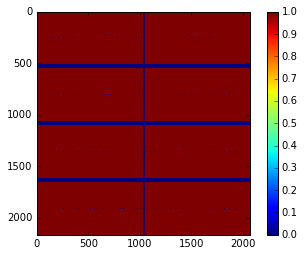

In [17]:
plt.figure()
plt.imshow(imgs.md['pixel_mask'])
plt.colorbar()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

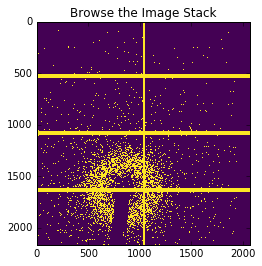

<function __main__.view_image>

In [18]:
from ipywidgets import interact

def view_image(i):
    plt.imshow(imgs[i], interpolation='nearest', cmap='viridis', vmin=0, vmax=1e0)
    plt.title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, 2999))

In [21]:
#hey, let's see if any images are bad!
imgsum = [np.sum(img*imgs.md['pixel_mask']) for img in imgs[::25]]

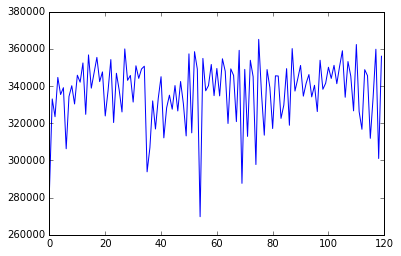

In [22]:
%matplotlib inline
plt.plot(imgsum)

### Get the Averaged Image Data

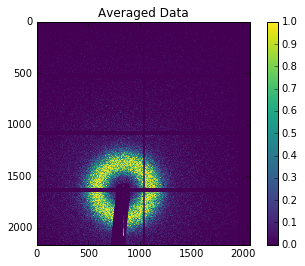

In [34]:
avg_img = np.average(imgs[::100], axis=0) * imgs.md['pixel_mask']
# Plot the result
fig, ax = plt.subplots()
im = ax.imshow(avg_img, vmin=0, vmax=1e0, cmap='viridis')
fig.colorbar(im)
ax.set_title("Averaged Data")
plt.show()

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


In [36]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as utils

## Note:  Enter the following experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [37]:
imgs.md

{'beam_center_x': 0.0,
 'beam_center_y': 0.0,
 'count_time': 0.0039962204,
 'detector_distance': 1000.0,
 'frame_time': 0.0040000002,
 'framerate': 249.99998812563774,
 'incident_wavelength': 1.3811316,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [38]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

## Create the mask file

More information : https://github.com/Nikea/xray-vision/blob/master/xray_vision/mask/manual_mask.py

In [51]:
%matplotlib notebook

In [49]:
ManualMask??

<IPython.core.display.Javascript object>


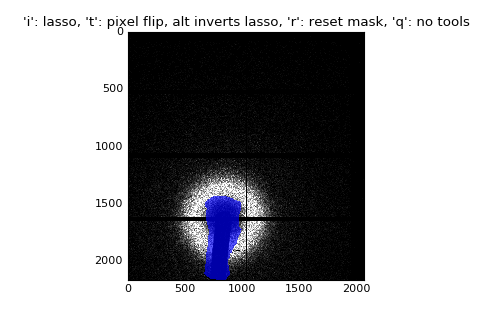

In [53]:
fig, ax = plt.subplots()
m = ManualMask(ax, avg_img, vmin=0, vmax=1e0)

<IPython.core.display.Javascript object>


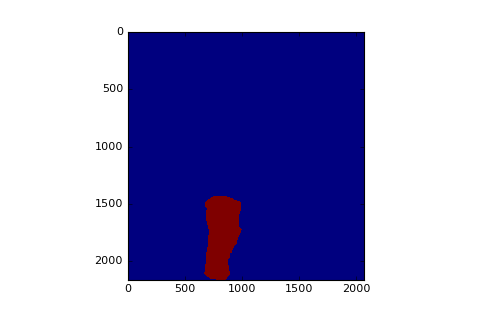

In [55]:
new_mask = m.mask

plt.imshow(new_mask)
plt.show()

### Combine the hand-drawn mask and the pixel mask

In [56]:
mask = ~m.mask * imgs.md['pixel_mask']

In [57]:
%matplotlib notebook

<IPython.core.display.Javascript object>


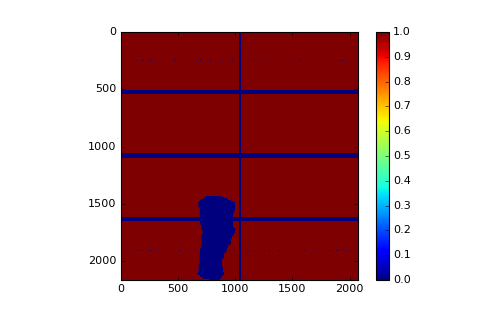

In [59]:
plt.figure()
plt.imshow(mask)
plt.colorbar()

## Get the approximate center and see the statistic to make sure 

In [63]:
center = (1634.66, 838.6)  # center of the speckle pattern
# center = (imgs.md['beam_center_x'], imgs.md['beam_center_y'])

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [64]:
bin_centers, ring_averages= roi.circular_average(avg_img*mask, center, threshold=0, nx=1000,
                                         pixel_size=(dpix, dpix))

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

<IPython.core.display.Javascript object>


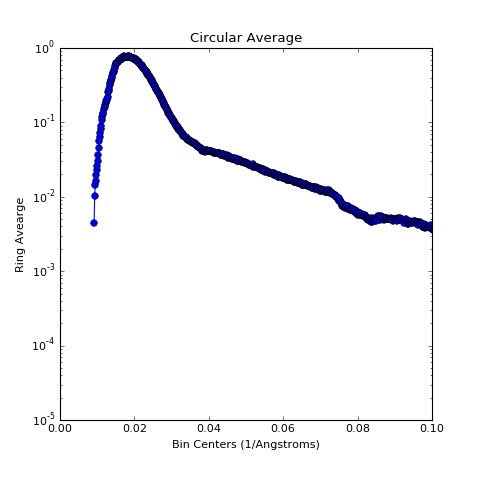

In [65]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title("Circular Average")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.1)
plt.show()

## Plot Kymograph (Waterfall plot) for a vertical and hortizontal cuts


Note : Give coordinates of the upper-left corner and width and height of each
rectangle: e.g., [(x, y, w, h), (x, y, w, h)]


In [ ]:
vert_rect = ((1500, 803, 40, 20), (1554, 546, 30, 40), (1454, 1098, 20, 60)) 

V_K_label_array = roi.rectangles(vert_rect, avg_img.shape)
plt.figure()
plt.imshow(V_K_label_array)
plt.show()

In [ ]:
veri_kymo = roi.kymograph(imgs, V_K_label_array*mask, num = 1)

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
ax.set_xlabel('Pixel')
ax.set_ylabel('Frame')
ax.set_title('Kymograph')
ax.imshow(veri_kymo, cmap='gist_earth')
plt.show()

In [ ]:
hori_kymo = roi.kymograph(imgs, V_K_label_array*mask, num=2)

fig, ax = plt.subplots(figsize=(14,10))
ax.set_xlabel('Pixel')
ax.set_ylabel('Frame')
ax.set_title('Kymograph')
ax.imshow(hori_kymo, cmap='gist_earth')
plt.show()

## Create label array (Q rings)

In [82]:
inner_radius = 150# radius of the first ring
width = 10        # width of each ring
spacing = 3      # no spacing between rings
num_rings = 15   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 150.,  160.],
       [ 163.,  173.],
       [ 176.,  186.],
       [ 189.,  199.],
       [ 202.,  212.],
       [ 215.,  225.],
       [ 228.,  238.],
       [ 241.,  251.],
       [ 254.,  264.],
       [ 267.,  277.],
       [ 280.,  290.],
       [ 293.,  303.],
       [ 306.,  316.],
       [ 319.,  329.],
       [ 332.,  342.]])

In [83]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_val

array([[ 0.01023591,  0.0109183 ],
       [ 0.01112302,  0.01180541],
       [ 0.01201013,  0.01269252],
       [ 0.01289723,  0.01357962],
       [ 0.01378434,  0.01446673],
       [ 0.01467144,  0.01535383],
       [ 0.01555855,  0.01624093],
       [ 0.01644565,  0.01712803],
       [ 0.01733275,  0.01801513],
       [ 0.01821985,  0.01890223],
       [ 0.01910694,  0.01978933],
       [ 0.01999404,  0.02067642],
       [ 0.02088113,  0.02156351],
       [ 0.02176823,  0.0224506 ],
       [ 0.02265532,  0.02333769]])

<IPython.core.display.Javascript object>


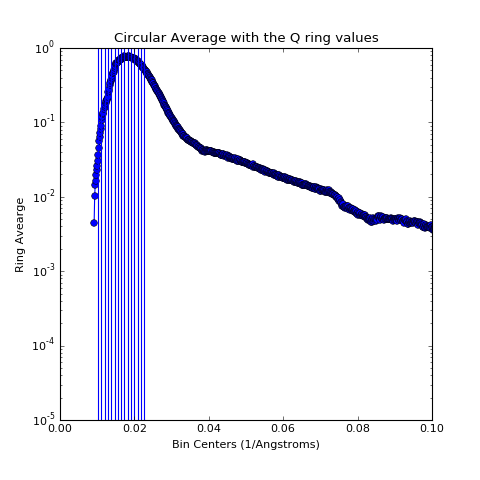

In [84]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title("Circular Average with the Q ring values")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.1)
for i in range(num_rings):
    axes.axvline(q_ring_val[i, 0])
plt.show()

<IPython.core.display.Javascript object>


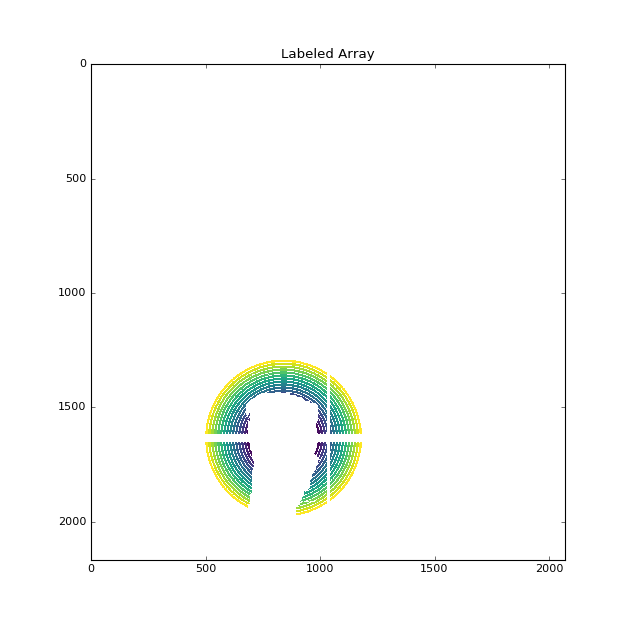

In [85]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask
% matplotlib notebook
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis')
plt.show()

##  Mean intensities for each ring

In [86]:
mask_data = imgs[::50]*mask
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

In [81]:
num_rings

15

In [87]:
mean_int_sets.shape

(60, 15)

<IPython.core.display.Javascript object>


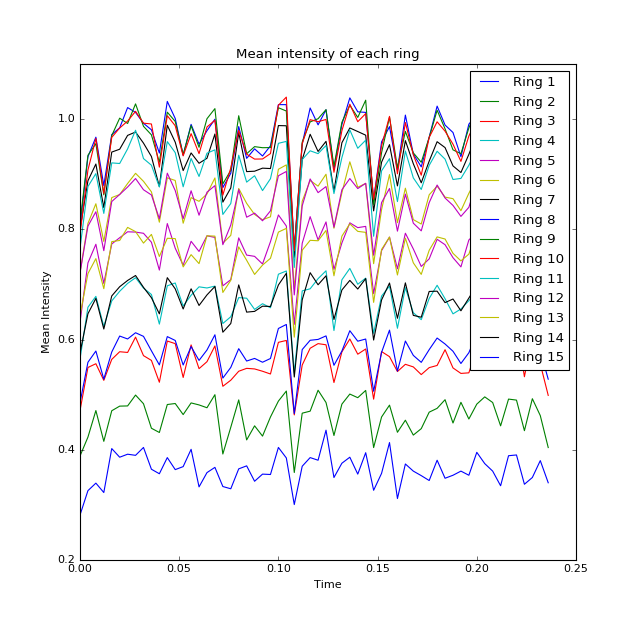

In [88]:
time = np.arange(len(mask_data))*timeperframe  # get the time for each frame


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(time, mean_int_sets[:,i], label="Ring "+str(i+1))
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py

In [89]:
subset = imgs[:100]

In [97]:
class Masker:
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask

In [92]:
masker = Masker(imgs, mask)

Frame([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
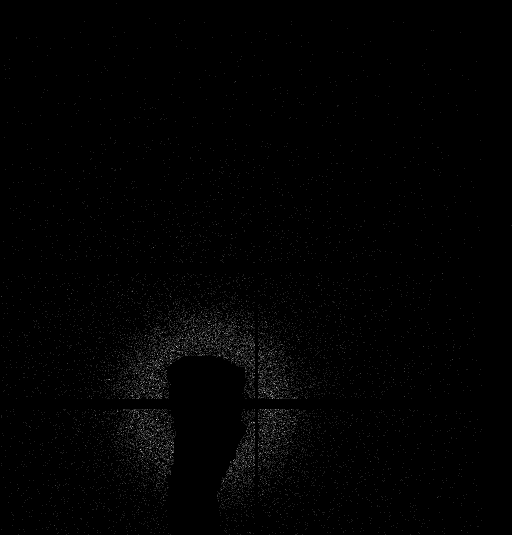

In [95]:
masker[1000]

In [96]:
num_lev = 9  
num_buf = 8

g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf, ring_mask,
                                             masker)

In [99]:
%matplotlib inline

### Plot the one time correlation functions

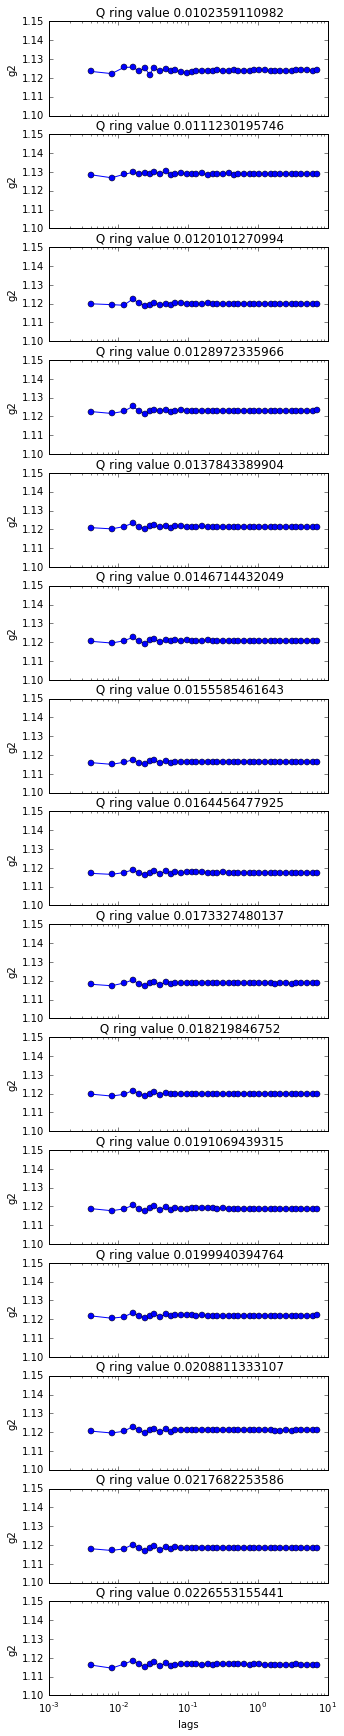

In [100]:
lags = lag_steps*timeperframe

fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5, 30))
axes[num_rings-1].set_xlabel("lags")
for i in range(num_rings):
    axes[i].set_ylabel("g2") 
    axes[i].set_title(" Q ring value " + str(q_ring_val[i, 0]))
    axes[i].semilogx(lags, g2[:, i], '-o', markersize=6)
    axes[i].set_ylim(bottom=1.10, top=1.15)
plt.show()